In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sklearn, os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

/home/yloukachev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}

ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [3]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])
df = merged_dataset.to_dataframe().reset_index()

df['A'], df['B'], df['C'] = np.sin(df['ylat']), np.sin(df['xlon'])*np.cos(df['ylat']), -np.cos(df['xlon'])*np.cos(df['ylat'])

df.dropna(subset=['pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
shift_param = int(df.shape[0]/df['time'].nunique())

df.drop(columns=['xlon', 'ylat', 'time', 'TLONG', 'TLAT'], inplace=True)

print('We shift the dataset by %i rows to incorporate the sequential nature of the data.' %shift_param)
print('The dataset contains %i years worth of data.' %((df.shape[0]/shift_param)/12))

We shift the dataset by 41070 rows to incorporate the sequential nature of the data.
The dataset contains 35 years worth of data.


In [4]:
scaler = StandardScaler()
# not scaling the data for now...
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(df)

# shift the time series down by one timestep
scaled_df.columns = df.columns
scaled_df['pCO2(t)'] = scaled_df['pCO2']
scaled_df = pd.concat([scaled_df[scaled_df.columns[:-2]].shift(-shift_param), scaled_df['pCO2(t)']], axis=1)

# remove null values generated by shifting the time series
scaled_df.dropna(how='any', inplace=True)

In [5]:
scaled_df.head()

,pCO2,XCO2,SST,SSS,MLD,Chl,A,B,pCO2(t)
20,259.943180,340.96225,-1.643371,33.400482,22.005390,0.064728,-0.375524,0.444338,256.390077
21,264.257161,340.96225,-1.661482,33.388058,23.062262,0.079743,0.576990,0.391571,262.338616
22,269.302537,340.96225,-1.593351,33.278996,22.597095,0.077933,0.999021,-0.021204,261.956626
23,275.715089,340.96225,-1.370293,33.126888,22.107952,0.069886,0.502557,-0.414484,262.739347
24,285.947764,340.96225,-0.831875,33.111485,23.515684,0.060309,-0.455956,-0.426690,266.288585


In [6]:
values = scaled_df.values
n_train_months = shift_param * 12 * 30 # training on 30 years and evaluating on five years

train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [7]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14785200, 1, 8) (14785200,) (2464200, 1, 8) (2464200,)


In [16]:
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1024, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop',  metrics=['mse'])

history = model.fit(train_X, train_y, epochs=11, batch_size=shift_param, validation_data=(test_X, test_y), shuffle=False)

Train on 14785200 samples, validate on 2464200 samples
Epoch 1/11
14785200/14785200 [==============================] - 107s 7us/step - loss: 37.0554 - mean_squared_error: 3148.0367 - val_loss: 22.0377 - val_mean_squared_error: 845.2593
Epoch 2/11
14785200/14785200 [==============================] - 105s 7us/step - loss: 28.9660 - mean_squared_error: 1273.2016 - val_loss: 37.7020 - val_mean_squared_error: 1898.7221
Epoch 3/11
14785200/14785200 [==============================] - 104s 7us/step - loss: 27.1693 - mean_squared_error: 1107.0043 - val_loss: 18.9274 - val_mean_squared_error: 643.0822
Epoch 4/11
14785200/14785200 [==============================] - 105s 7us/step - loss: 25.6456 - mean_squared_error: 1007.8035 - val_loss: 34.5209 - val_mean_squared_error: 1560.7523
Epoch 5/11
14785200/14785200 [==============================] - 105s 7us/step - loss: 24.2950 - mean_squared_error: 891.8169 - val_loss: 16.2409 - val_mean_squared_error: 489.3710
Epoch 6/11
14785200/14785200 [=========

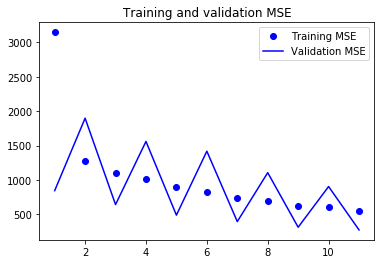

In [18]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

The LSTM model below does not use a lagged dependency when processing sequentially processing the data.

In [4]:
df['pCO2'] = df.pop('pCO2')

df.head()

,XCO2,SST,SSS,MLD,Chl,A,B,C,pCO2
20,340.848541,-1.552322,33.641834,12.729663,1.128493,-0.375524,0.444338,-0.813355,256.390077
21,340.848541,-1.626047,33.667816,19.951666,0.900315,0.576990,0.391571,-0.716767,262.338616
22,340.848541,-1.607591,33.572289,19.510101,0.635458,0.999021,-0.021204,0.038813,261.956626
23,340.848541,-1.496069,33.424641,20.714338,0.420227,0.502557,-0.414484,0.758709,262.739347
24,340.848541,-1.207762,33.317802,20.579535,0.380468,-0.455956,-0.426690,0.781051,266.288585


In [6]:
values = df.values
n_train_months = shift_param * 12 * 30 # training on 30 years and evaluating on five years

train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14785200, 1, 8) (14785200,) (2505270, 1, 8) (2505270,)


In [15]:
model = Sequential()
model.add(LSTM(256, batch_size = shift_param, input_shape=(train_X.shape[1], train_X.shape[2]), 
               return_sequences=True, stateful=True))
model.add(LSTM(128, stateful=True))
model.add(Dense(1024, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop',  metrics=['acc', 'mse'])

history = model.fit(train_X, train_y, epochs=33, batch_size=shift_param, validation_data=(test_X, test_y), shuffle=False)

Train on 14785200 samples, validate on 2505270 samples
Epoch 1/33
14785200/14785200 [==============================] - 113s 8us/step - loss: 39.5526 - acc: 2.7054e-07 - mean_squared_error: 3406.5990 - val_loss: 29.8220 - val_acc: 0.0000e+00 - val_mean_squared_error: 1596.7729
Epoch 2/33
14785200/14785200 [==============================] - 104s 7us/step - loss: 30.5090 - acc: 6.7635e-08 - mean_squared_error: 1635.9322 - val_loss: 36.7893 - val_acc: 3.9916e-07 - val_mean_squared_error: 2211.4273
Epoch 3/33
14785200/14785200 [==============================] - 104s 7us/step - loss: 27.3813 - acc: 5.4108e-07 - mean_squared_error: 1350.9719 - val_loss: 22.5500 - val_acc: 0.0000e+00 - val_mean_squared_error: 1037.8216
Epoch 4/33
14785200/14785200 [==============================] - 104s 7us/step - loss: 25.9545 - acc: 3.3818e-07 - mean_squared_error: 1259.4085 - val_loss: 32.4550 - val_acc: 3.9916e-07 - val_mean_squared_error: 1808.1453
Epoch 5/33
14785200/14785200 [===========================

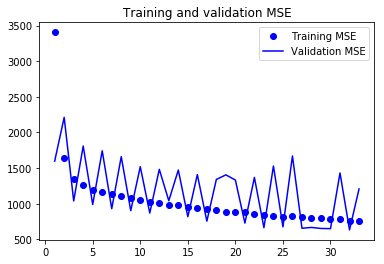

In [16]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()